In [1]:
from pathlib import Path
from typing import List
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import load_workload_data as ld
import load_benchmark_data as be
import matplotlib.pyplot as plt

In [2]:
# Init

workloads: Path = Path("../data/workloads/")

def plot_stacked(data: DataFrame, x: str, y: str, hue: str, hue_order: List[str]=None, order: List[str]=None, color=None):
    df_plottable: DataFrame = data.groupby([x, hue])[y].sum().reset_index().pivot(columns=hue, index=x, values=y)
    if hue_order:
        assert sorted(hue_order) == sorted(list(df_plottable))
        df_plottable = df_plottable[hue_order]
    if order:
        df_plottable = df_plottable.reindex(order)
    df_plottable.plot(kind="bar", stacked=True, ax=plt.gca(), rot=0)
    plt.ylabel(y)

def plot_workload(workload_folder: Path):
    df = ld.get_workload_data(workload_folder)
    x_order: List[str] = sorted(df[ld.DATA_TYPE].drop_duplicates(), reverse=True)
    order: List[str] = ["TABLE_SCAN", "JOIN", "AGGREGATE", "PROJECTION"]
    order_filtered = [operator for operator in order if operator in list(df[ld.OPERATOR_TYPE])]
    plot_stacked(data=df, x=ld.DATA_TYPE, y=ld.RUNTIME_S, hue=ld.OPERATOR_TYPE, hue_order=order_filtered, order=x_order)

In [3]:
import sys
from enum import Enum
from pathlib import Path
from typing import List, Tuple

import pandas as pd
from pandas import DataFrame

class Operator(str, Enum):
    SCAN = "table_scans",
    PROJECTION = "projections",
    AGGREGATE = "aggregates",
    JOIN = "joins"

RUNTIME_S = "Runtime (in s)"
COLUMN_TYPE = "Data Access"
QUERY_HASH = "QUERY_HASH"
OPERATOR_HASH = "OPERATOR_HASH"
DATA_TYPE = "Data Type"
TABLE_NAME = "TABLE_NAME"
COLUMN_NAME = "COLUMN_NAME"
OPERATOR_TYPE = "Operator"
WORKLOAD = "WORKLOAD"

BENCHMARKS: List[str] = ["CH-benCHmark", "Join Order Benchmark", "TPC-C", "TPC-DS", "TPC-H"]

def get_with_column_data_type(table: DataFrame, metadata: DataFrame) -> DataFrame:
    table[TABLE_NAME] = table[TABLE_NAME].astype(object)
    table[COLUMN_NAME] = table[COLUMN_NAME].astype(object)
    table_with_data_types = table.merge(metadata, how="left", on=[TABLE_NAME, COLUMN_NAME])
    return table_with_data_types

def get_grouped_by_operator_hash(table: DataFrame) -> DataFrame:
    grouped_by_operator_hash: DataFrame = table.groupby([QUERY_HASH, OPERATOR_HASH], as_index=False)[RUNTIME_S] \
        .agg(["count", "mean"])
    grouped_by_operator_hash[RUNTIME_S] = [mean / count for mean, count in zip(grouped_by_operator_hash["mean"], grouped_by_operator_hash["count"])]
    grouped_by_operator_hash = grouped_by_operator_hash.reset_index()

    table = table.drop(RUNTIME_S, axis=1)
    table = table.merge(grouped_by_operator_hash, on=[QUERY_HASH, OPERATOR_HASH])
    return table

def get_workload_data(workload_directory: Path) -> DataFrame:
    # Initialize
    metadata = pd.read_csv(workload_directory / "column_meta_data.csv", delimiter="|")
    metadata = metadata.rename(columns={"DATA_TYPE": DATA_TYPE})
    workload_name: str = workload_directory.name
    aggregated_data = []
    for operator in list(Operator):
        # print(f"Processing {operator}")

        # Get Dataframe
        table: DataFrame = pd.read_csv(workload_directory / f"{operator}.csv", delimiter="|")
        #print(table)
        table["RUNTIME_NS"] = [runtime / 1e9 for runtime in table["RUNTIME_NS"]]
        table = table.rename(columns={"RUNTIME_NS" : RUNTIME_S, "DATA_TYPE": DATA_TYPE,
                                      "COLUMN_TYPE": COLUMN_TYPE, "OPERATOR_TYPE": OPERATOR_TYPE})
        table[WORKLOAD] = [workload_name for i in range(len(table))]

        # Preprocess in case that we have a join (since both columns that we join on have the same type, we
        # select the left column as the "true" column)
        if operator is Operator.JOIN:
            table = table.rename({f"LEFT_COLUMN_NAME": COLUMN_NAME, f"LEFT_COLUMN_TYPE":COLUMN_TYPE,
                                 f"LEFT_TABLE_NAME":TABLE_NAME}, axis="columns")

        # Groupby to avoid having missleading results
        if operator is not Operator.SCAN:
            table = get_grouped_by_operator_hash(table)
        table = get_with_column_data_type(table, metadata)

        # Calculate Information
        #grouped_by_column_type: DataFrame = table.groupby([COLUMN_TYPE, DATA_TYPE, OPERATOR_TYPE, WORKLOAD], as_index=False)[RUNTIME_S].sum().reset_index()
        # 0: DATA, 1: REFERENCE
        try:
            g = table.groupby(COLUMN_TYPE)["INPUT_ROW_COUNT"].sum()
            aggregated_data.append((str(operator), g[0], g[1] if len(g) > 1 else 0))
        except KeyError:
             continue
    return aggregated_data

get_workload_data(workloads / "TPC-H")

[('Operator.SCAN', 9246722945, 4917585364),
 ('Operator.PROJECTION', 47242986, 17128375159),
 ('Operator.AGGREGATE', 13438428534, 3192441811)]

In [4]:
relative = []
for b in ["TPC-H", "TPC-DS", "CH-benCHmark", "TPC-C", "Join Order Benchmark"]:
    d = get_workload_data(workloads / b)
    data = sum([v[1] for v in d])
    ref = sum([v[2] for v in d])
    print(b, data, ref)

    table: DataFrame = pd.read_csv(workloads / b / f"table_scans.csv", delimiter="|")
    #print(table)
    table["selectivity"] = table["OUTPUT_ROW_COUNT"] / table["INPUT_ROW_COUNT"]
    #break

    relative.append((b, data, ref, table["selectivity"].mean()))

TPC-H 22732394465 25238402334
TPC-DS 16627636038 20708325793
CH-benCHmark 2083708746 32951161654
TPC-C 117160359 741806245
Join Order Benchmark 24034060407 10168101967


In [9]:
df = pd.DataFrame(relative, columns=["Benchmark", "Sequential", "Non-sequential", "Selectivity"])
df

,Benchmark,Sequential,Non-sequential,Selectivity
0,TPC-H,22732394465,25238402334,0.407399
1,TPC-DS,16627636038,20708325793,0.238680
2,CH-benCHmark,2083708746,32951161654,0.109199
3,TPC-C,117160359,741806245,0.172734
4,Join Order Benchmark,24034060407,10168101967,0.630210


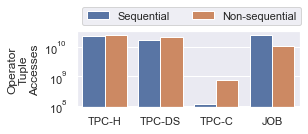

In [11]:
sns.set(rc={'figure.figsize':(4,1.4)})
df.loc[df["Benchmark"] == "Join Order Benchmark", "Benchmark"] = "JOB"
df.loc[df["Benchmark"] == "CH-benCHmark", "Benchmark"] = "CH-\nbenCHmark"



tidy = df.melt(id_vars='Benchmark').rename(columns=str.title)
tidy["Access"] = tidy["Variable"]


tidy = tidy[tidy["Benchmark"] != "CH-\nbenCHmark"]

d = tidy[tidy["Variable"] != "Selectivity"]
ax= sns.barplot(x='Benchmark', y='Value', hue='Access', data=d)

ax.legend(loc='center left', bbox_to_anchor=(-0.0, 1.2), ncol=2)

ax.set_yscale('log')
#ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
#plt.ylim((1, df["Poslist Accesses"].max() + df["Direct Accesses"].max() + 10**6))

ax.set_ylabel("Operator\nTuple\nAccesses")
ax.set_xlabel("")
plt.savefig(f"visualizations/benchmark_accesses.svg", format="svg")

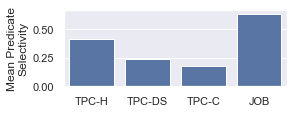

In [12]:
sns.set(rc={'figure.figsize':(4,1.4)})

ax= sns.barplot(x='Benchmark', y='Value', hue='Access', data=tidy[tidy["Variable"] == "Selectivity"])

#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
#plt.ylim((1, df["Poslist Accesses"].max() + df["Direct Accesses"].max() + 10**6))
ax.get_legend().remove()
ax.set_ylabel("Mean Predicate\nSelectivity")
ax.set_xlabel("")
plt.savefig(f"visualizations/benchmark_selectivity.svg", format="svg")

In [13]:
abc = df[df["Benchmark"] != "CH-\nbenCHmark"]
abc["total_access"] = abc["Sequential"] + abc["Non-sequential"]
abc["access_percentage"] = abc["Non-sequential"] / abc["total_access"]
1 - abc["access_percentage"].mean()

<ipython-input-13-52aa0b082011>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abc["total_access"] = abc["Sequential"] + abc["Non-sequential"]
<ipython-input-13-52aa0b082011>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abc["access_percentage"] = abc["Non-sequential"] / abc["total_access"]


0.43958358996123537

In [45]:
abc["Selectivity"].mean()

0.3622557283669362